In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'src_new')))

from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

import logging
logging.basicConfig(level=logging.INFO)
logging.getLogger("httpx").setLevel(logging.WARNING)
logging.getLogger("openai").setLevel(logging.WARNING)

In [2]:
from src_new.utils.config_loader import ConfigLoader

config_loader = ConfigLoader()
base_config = config_loader.load_configs()
print("Config sections:", list(base_config.keys()))

INFO:numexpr.utils:NumExpr defaulting to 16 threads.
INFO:src_new.utils.config_loader:Config loader initialized with root: c:\Users\Viriya Duch Sam\Desktop\Thesis Research\ecs_msc_project\configs
INFO:src_new.utils.config_loader:Loading multi-file config structure from c:\Users\Viriya Duch Sam\Desktop\Thesis Research\ecs_msc_project\configs
INFO:src_new.utils.config_loader:Configuration validation passed successfully
INFO:src_new.utils.config_loader:Multi-file config loading completed successfully


Config sections: ['metadata', 'labels', 'subreddits', 'subreddit_ids', 'defaults', 'paths', 'caching', 'data_processing', 'preprocessing', 'modeling', 'training']


In [3]:
from src_new.data.preprocessing import PreprocessingPipeline

preprocessor = PreprocessingPipeline(configs=base_config)
try:
    data = preprocessor.run(
        force_recompute_embeddings=True,
        extract_topics=True,
        api_key=api_key,
        force_recompute_topics=False,

    )
except Exception as e:
    print(f"Error during preprocessing: {e}")
    data = None

INFO:src_new.data.preprocessing.data_loader:DataLoader initialized with data_path: data/raw/deb_label.csv
INFO:src_new.data.preprocessing.comment_embedder:CommentTextEmbedder initialized with cache_enabled=True, model_type=sbert, model_name=all-MiniLM-L6-v2, batch_size=100
INFO:src_new.data.preprocessing.temporal:TemporalProcessor initialized with configuration:
INFO:src_new.data.preprocessing.temporal: + Window strategy: fixed
INFO:src_new.data.preprocessing.temporal: + Default window size: 178 days
INFO:src_new.data.preprocessing.temporal: + Binning method: fixed_interval
INFO:src_new.data.preprocessing.temporal: + Overlap allowed: False
INFO:src_new.data.preprocessing.temporal: + Min comments per window: 10
INFO:src_new.data.preprocessing.pipeline:Starting preprocessing pipeline
INFO:src_new.data.preprocessing.pipeline:Step 1: Loading and cleaning data
INFO:src_new.data.preprocessing.data_loader:Starting data loading and cleaning process
INFO:src_new.data.preprocessing.data_loader:L

In [6]:
# Save comments, replies and pairs_all df to pickle for later use
import pandas as pd

if data is not None:
    comments_df = data.comments
    replies_df = data.replies
    pairs_all_df = data.pairs_data['pairs_all']
    pd.to_pickle(comments_df, "data/cache/comments.pkl")
    pd.to_pickle(replies_df, "data/cache/replies.pkl")
    pd.to_pickle(pairs_all_df, "data/cache/pairs_all.pkl")

# Read head
display(pd.read_pickle("data/cache/replies.pkl").head(3))
display(pd.read_pickle("data/cache/comments.pkl").head(3))
display(pd.read_pickle("data/cache/pairs_all.pkl").head(3))

label dst_comment_id src_comment_id submission_id  \
0      0        gfvmv5x        gfvmzei        kd0se4   
1      2        gyn3we6        gyn4ruu        nfrunb   
2      0        gbh1w5x        gbh2dxt        jpv1jr   

                                    dst_comment_text  \
0  So now that they have elected Biden how can we...   
1  Tlaib, your family is Hamas. Funded by Iran a ...   
2  Most Republicans are happy with Biden as he wi...   

                                    src_comment_text  \
0  They haven't, it is a contested election. The ...   
1  She was not truthful when she swore her oath o...   
2  I'm not happy about it but I'm not going out a...   

                                     submission_text   subreddit  \
0  Forensic Audit: "We conclude that the Dominion...  republican   
1  Biden and The Squad's Tlaib stage heated confr...  republican   
2  President-elect Biden is projected to win Penn...  republican   

          dst_author  exact_time  ... is_self_reply src_text_length  \
0        guildarts15  1607998349  ...             0             103   
1  oppositeofoutside  1621387168  ...             0             183   
2             Rpdaca  1604773521  ...             0              95   

   dst_text_length  year  month day_of_week  hour  \
0              195  2020     12           1     2   
1              305  2021      5           2     1   
2              110  2020     11           5    18   

                                          embeddings  timestep  confidence  
0  [0.036776543, -0.047532145, 0.076586746, 0.011...         1         1.0  
1  [0.0055242963, -0.04908121, 0.06168418, 0.0273...         2         1.0  
2  [0.03693985, 0.026414156, 0.04610996, -0.04668...         1         1.0  

[3 rows x 26 columns]

subreddit_id submission_id comment_id          author  \
0             0        gcx1nx    fpdxjvv    sebastian404   
1             0        jb3iqr    g8t3cwl  anglo-francais   
2             0        k436d6    ge6ffh0      yuppwhynot   

                                                text  \
0  Well, lets look at what else he said, *"The on...   
1  the final nail in the coffin for ~~European~~ ...   
2  Because the EU has politely declined to fulfil...   

                                          embeddings           timestamp  \
0  [-0.036231328, 0.029959867, 0.035119407, 0.053... 2020-05-03 19:37:00   
1  [-0.015929654, 0.02505227, 0.08624149, -0.0224... 2020-10-14 15:43:00   
2  [-0.0068593123, 0.06960208, 0.071162924, -0.08... 2020-11-30 19:02:00   

   is_parent  timestep  
0          1         7  
1          1         8  
2          1         9

subreddit_id  timestep          src_author      dst_author  n_disagree  \
0             0         0      Lumpy_Custard_     batusfinkus           1   
1             0         0  captain_blackadder  Lumpy_Custard_           1   
2             0         1             APB2710        prodmerc           1   

   n_neutral  n_agree  mean_agg_frac  mean_kappa  mean_confidence  \
0          0        1       0.833333    0.666667         0.611111   
1          0        0       0.666667    0.333333         0.222222   
2          0        0       1.000000    1.000000         1.000000   

   std_confidence  min_confidence  max_confidence           net_vector  
0        0.549972        0.222222        1.000000  [0.818, 0.0, 0.182]  
1        0.000000        0.222222        0.222222      [1.0, 0.0, 0.0]  
2        0.000000        1.000000        1.000000      [1.0, 0.0, 0.0]

## **Data Analysis**

### **Basic Interaction Statistics**

In [7]:
import matplotlib.pyplot as plt

from src_new.utils.visualization import TopicVisualizer, TemporalVisualizer, SubredditVisualizer
from src_new.modules.analysis import ReplyStatistics, DatasetStatistics, TopicStatistics

raw = pd.DataFrame(data.raw) if data else None
replies = pd.DataFrame(data.replies) if data else None
submissions = pd.DataFrame(data.submissions_with_topics) if data else None

temporal_viz = TemporalVisualizer()
topic_viz = TopicVisualizer()
subreddit_viz = SubredditVisualizer()

In [8]:
# Basic Reply Statistics using new utilities
print("Raw Replies Data Statistics:")
raw_stats = ReplyStatistics.replies_data_statistics(raw)
display(raw_stats)

print("\nFiltered Replies Data Statistics (Non-Self-Replies):")
filtered_stats = ReplyStatistics.replies_data_statistics(replies)
display(filtered_stats)

# Print total after filtering self-replies
print(f"\nTotal Replies after filtering self-replies ({round(len(replies)/len(raw), 2)}%): {len(replies)}")

Raw Replies Data Statistics:


Earliest Date Latest Date  # Replies  % Self-Replies  \
subreddit                                                               
All                 2015-01-03  2021-05-19      42894            0.29   
blacklivesmatter    2020-05-27  2021-05-19       1929            0.67   
brexit              2016-06-21  2021-05-18      15745            0.27   
climate             2015-01-03  2021-05-18       5773            0.33   
democrats           2020-01-02  2021-05-19       9624            0.19   
republican          2020-01-02  2021-05-19       9823            0.33   

                  % Disagree  % Neutral  % Agree  # Unique Comments  \
subreddit                                                             
All                     39.6       26.0     34.4              75246   
blacklivesmatter        32.8       22.4     44.8               3477   
brexit                  41.6       29.2     29.2              28108   
climate                 40.6       27.7     31.7              10164   
democrats               35.9       21.9     42.2              16531   
republican              40.7       24.6     34.7              16966   

                  # Unique Authors  
subreddit                           
All                          23101  
blacklivesmatter              2516  
brexit                         722  
climate                       4580  
democrats                     6922  
republican                    8826


Filtered Replies Data Statistics (Non-Self-Replies):


Earliest Date Latest Date  # Replies  % Self-Replies  \
subreddit                                                               
All                 2015-01-03  2021-05-19      42770             0.0   
blacklivesmatter    2020-05-27  2021-05-19       1916             0.0   
brexit              2016-06-21  2021-05-18      15703             0.0   
climate             2015-01-03  2021-05-18       5754             0.0   
democrats           2020-01-02  2021-05-19       9606             0.0   
republican          2020-01-02  2021-05-19       9791             0.0   

                  % Disagree  % Neutral  % Agree  # Unique Comments  \
subreddit                                                             
All                     39.6       26.0     34.4              75034   
blacklivesmatter        32.9       22.4     44.7               3453   
brexit                  41.6       29.2     29.2              28039   
climate                 40.6       27.7     31.7              10131   
democrats               35.9       21.9     42.2              16499   
republican              40.7       24.6     34.7              16912   

                  # Unique Authors  
subreddit                           
All                          23074  
blacklivesmatter              2512  
brexit                         722  
climate                       4575  
democrats                     6915  
republican                    8814


Total Replies after filtering self-replies (1.0%): 42770


- The **DEBAGREEMENT** dataset spans 6+ years (2015-2021) with 42,894 total reply interactions across 5 politically-oriented subreddits, representing 23,101 unique authors. 

- We filter out about 124 self-replies, which represent about 1% of the entire dataset, leaving us with 42,770 replies.

### **Activity Patterns (3-Month Rolling Average)**

Rolling average by agreement label:


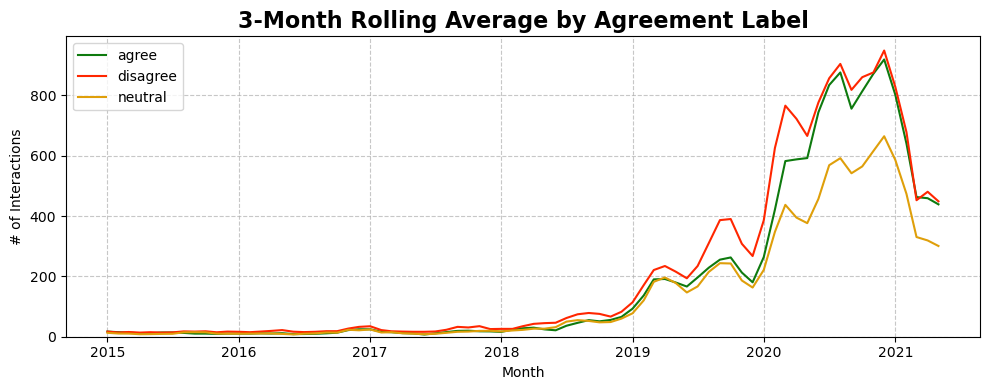


Rolling average by subreddit:


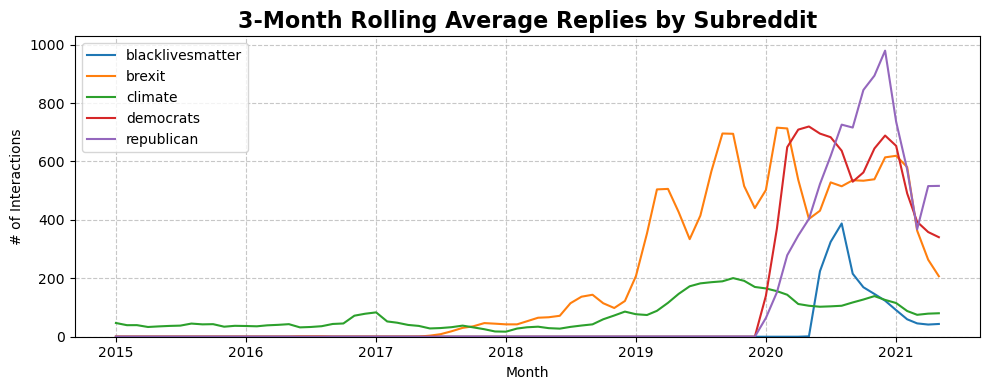

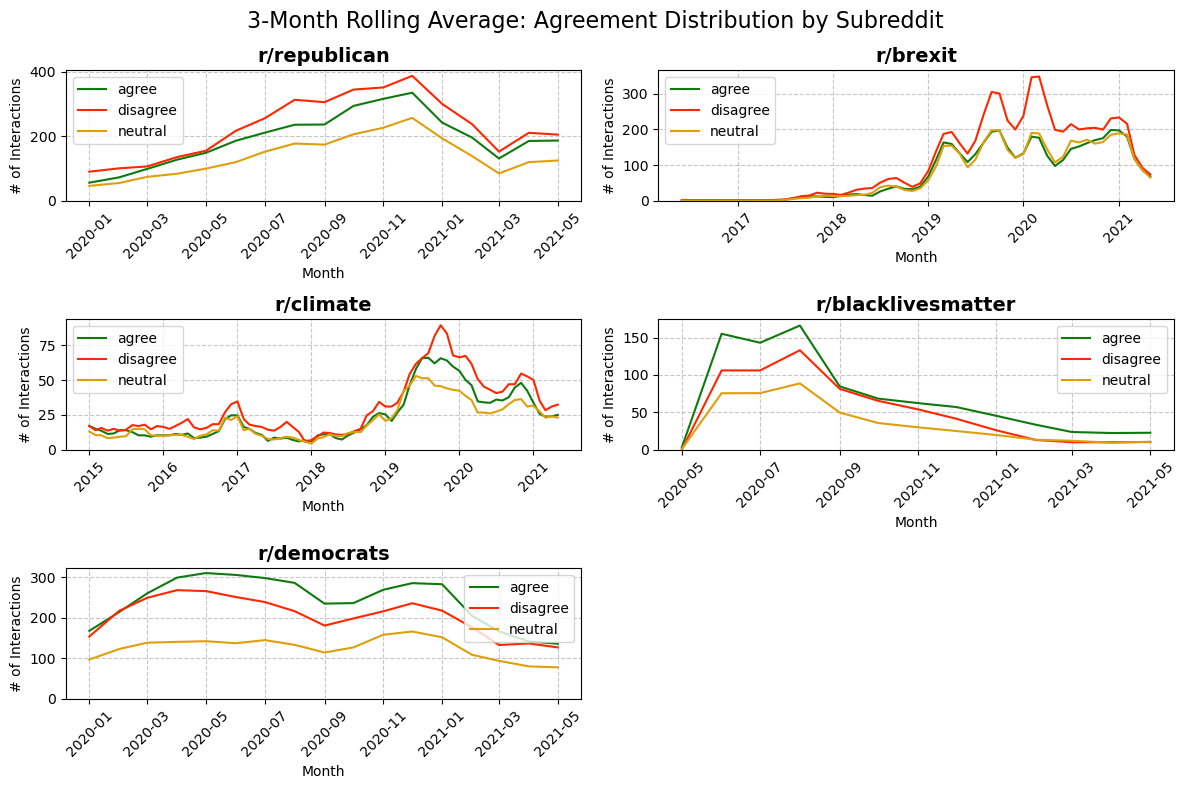

In [9]:
# Rolling average temporal visualizations using new utilities
n_months = 3

# Rolling averages by agreement label
print("Rolling average by agreement label:")
rolling_by_label = temporal_viz.plot_rolling_average_interactions(
    replies, n_months=3, group_by='label_desc', 
    title="3-Month Rolling Average by Agreement Label",
    figsize=(10, 4)
)
plt.show()

print("\nRolling average by subreddit:")
rolling_by_sub = temporal_viz.plot_rolling_average_interactions(
    replies, n_months=n_months, group_by='subreddit',
    title=f"{n_months}-Month Rolling Average Replies by Subreddit",
    figsize=(10, 4)
)
plt.show()

# Rolling average by subreddit and agreement label
rolling_by_sub_label = subreddit_viz.plot_subreddit_label_subplots(
    replies, n_months=3, 
    title="3-Month Rolling Average: Agreement Distribution by Subreddit",
    figsize=(12, 8)
)
plt.show()

### **Topic Distribution Analysis**

In [10]:
# Topic Statistics using new utilities
print("Topic Summary Statistics:")
topic_summary = TopicStatistics.create_topic_summary_statistics(submissions, raw)
display(topic_summary)

# Topic distribution matrix
print("\nTopic Distribution Matrix:")
topic_distribution = TopicStatistics.get_topic_distribution_matrix(submissions, raw)
print(f"Total unique topics: {len(topic_distribution)}")
print(f"Distribution matrix shape: {topic_distribution.shape}")

# Cross-subreddit topics
cross_topics = TopicStatistics.get_cross_subreddit_topics(topic_distribution, min_subreddits=2)
print(f"\nTopics appearing in multiple subreddits: {len(cross_topics)}")
if len(cross_topics) > 0:
    print("Top cross-subreddit topics:")
    for topic in cross_topics.index[:5]:
        counts = cross_topics.loc[topic]
        active_subs = counts[counts > 0]
        print(f"  - {topic[:60]}{'...' if len(topic) > 60 else ''}")
        print(f"    Active in: {list(active_subs.index)} (counts: {list(active_subs.values)})")

Topic Summary Statistics:


subreddit  num_submissions  num_unique_topics  \
0      ALL_SUBREDDITS            18080                 99   
1  r/blacklivesmatter              844                 19   
2            r/brexit             8155                 20   
3           r/climate             2790                 20   
4         r/democrats             3165                 20   
5        r/republican             3126                 20   

   avg_submissions_per_topic                          top_topic  \
0                      182.6  Brexit Party MEP Blames Remainers   
1                       44.4   Police Violence Against Children   
2                      407.8  Brexit Party MEP Blames Remainers   
3                      139.5        Renewable Energy Job Growth   
4                      158.2        COVID-19 Response Criticism   
5                      156.3       Police Shootings Controversy   

   top_topic_count                             least_topic  least_topic_count  \
0              717  Defunding the Police Budget Allocation                 19   
1               84  Defunding the Police Budget Allocation                 19   
2              717      Nigel Farage's Influence in Brexit                 88   
3              263         Greta Thunberg Climate Activism                 60   
4              254          NBA Stadiums as Polling Places                103   
5              219                   Cuomo's Controversies                 39   

   median_submissions_per_topic  
0                         153.0  
1                          40.0  
2                         413.5  
3                         136.0  
4                         160.5  
5                         167.5


Topic Distribution Matrix:
Total unique topics: 99
Distribution matrix shape: (99, 5)

Topics appearing in multiple subreddits: 0


#### **Topic Distribution Heatmap**


Topic Distribution Heatmap (Top 9):


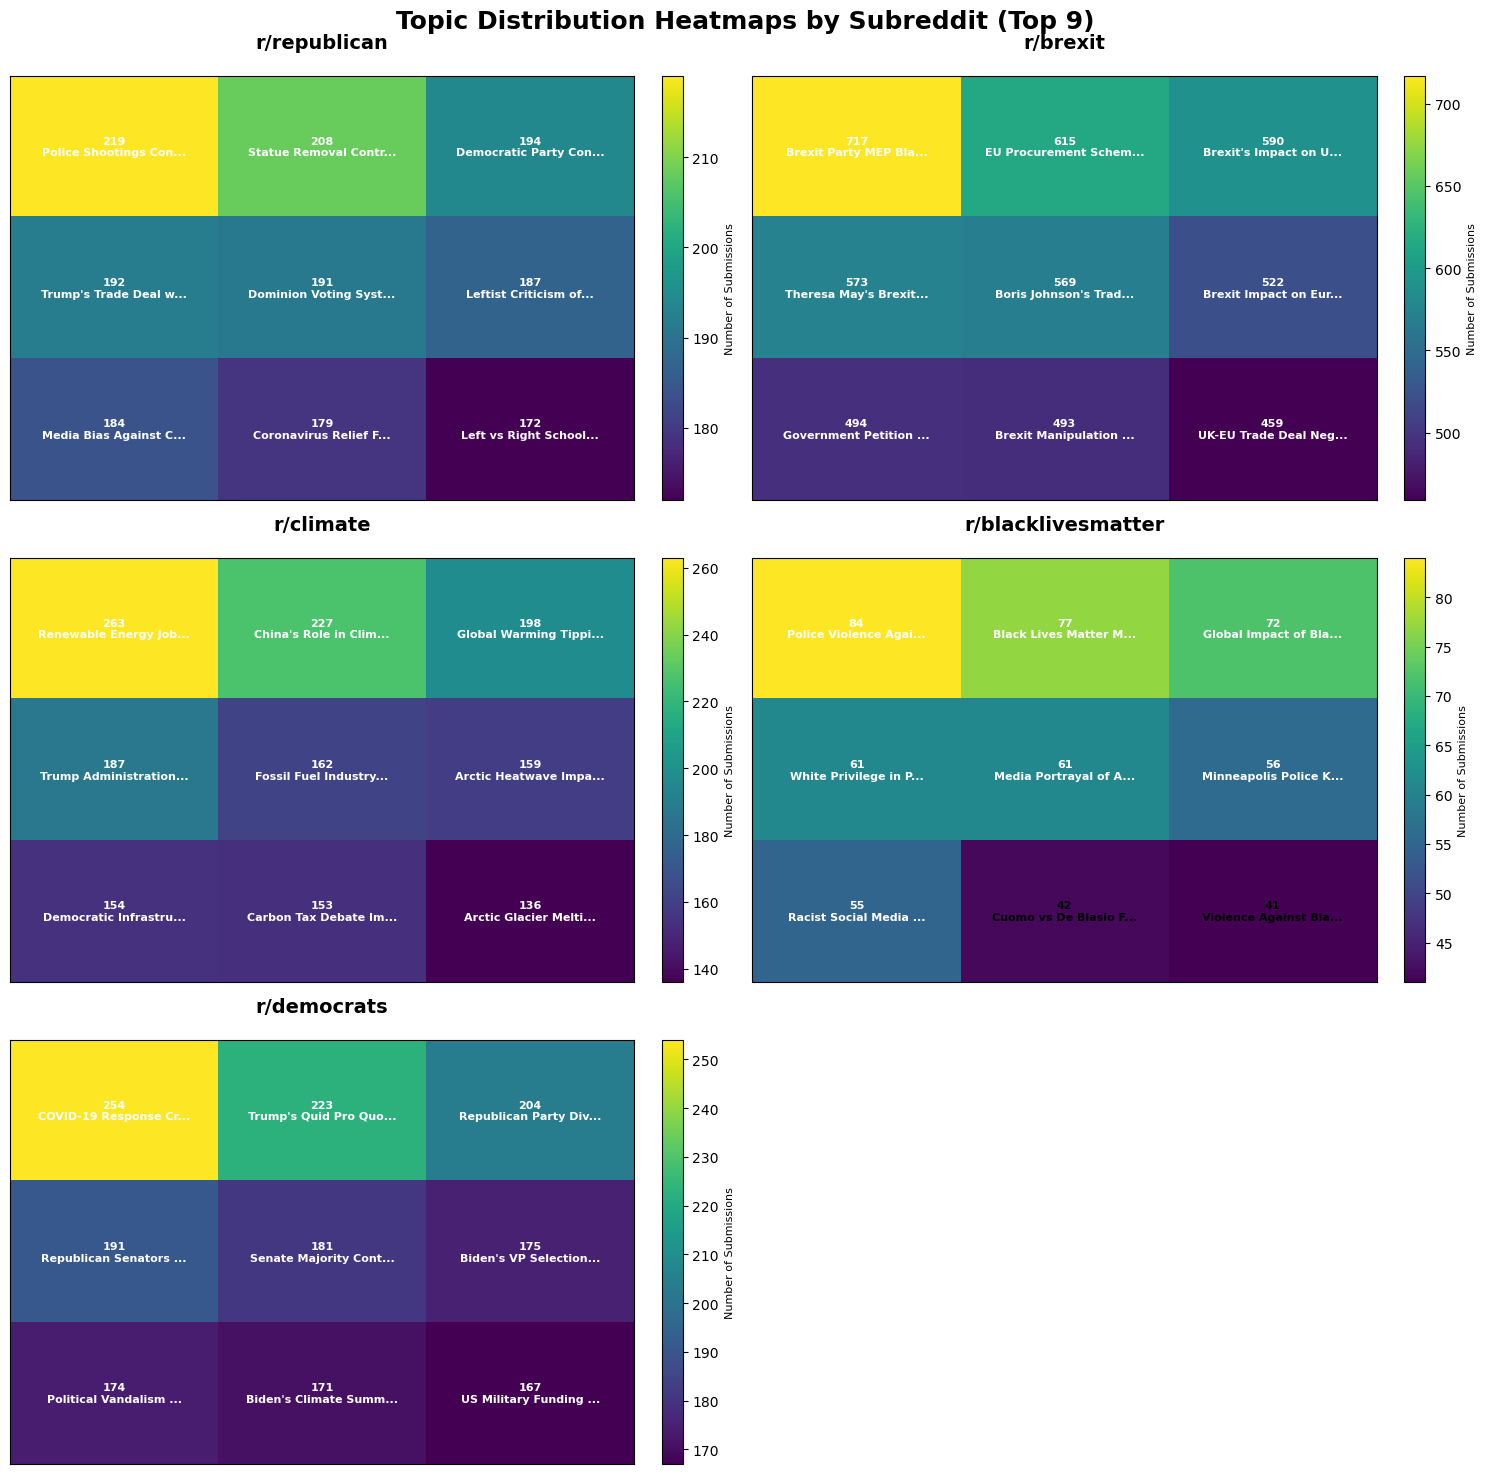

In [11]:
print("\nTopic Distribution Heatmap (Top 9):")
topics_heatmap = topic_viz.plot_topic_heatmaps_by_subreddit(
    submissions, raw, 
    top_topics_per_sub=9, 
    figsize=(15, 15)
)


Topic Agreement Patterns (Top 5):


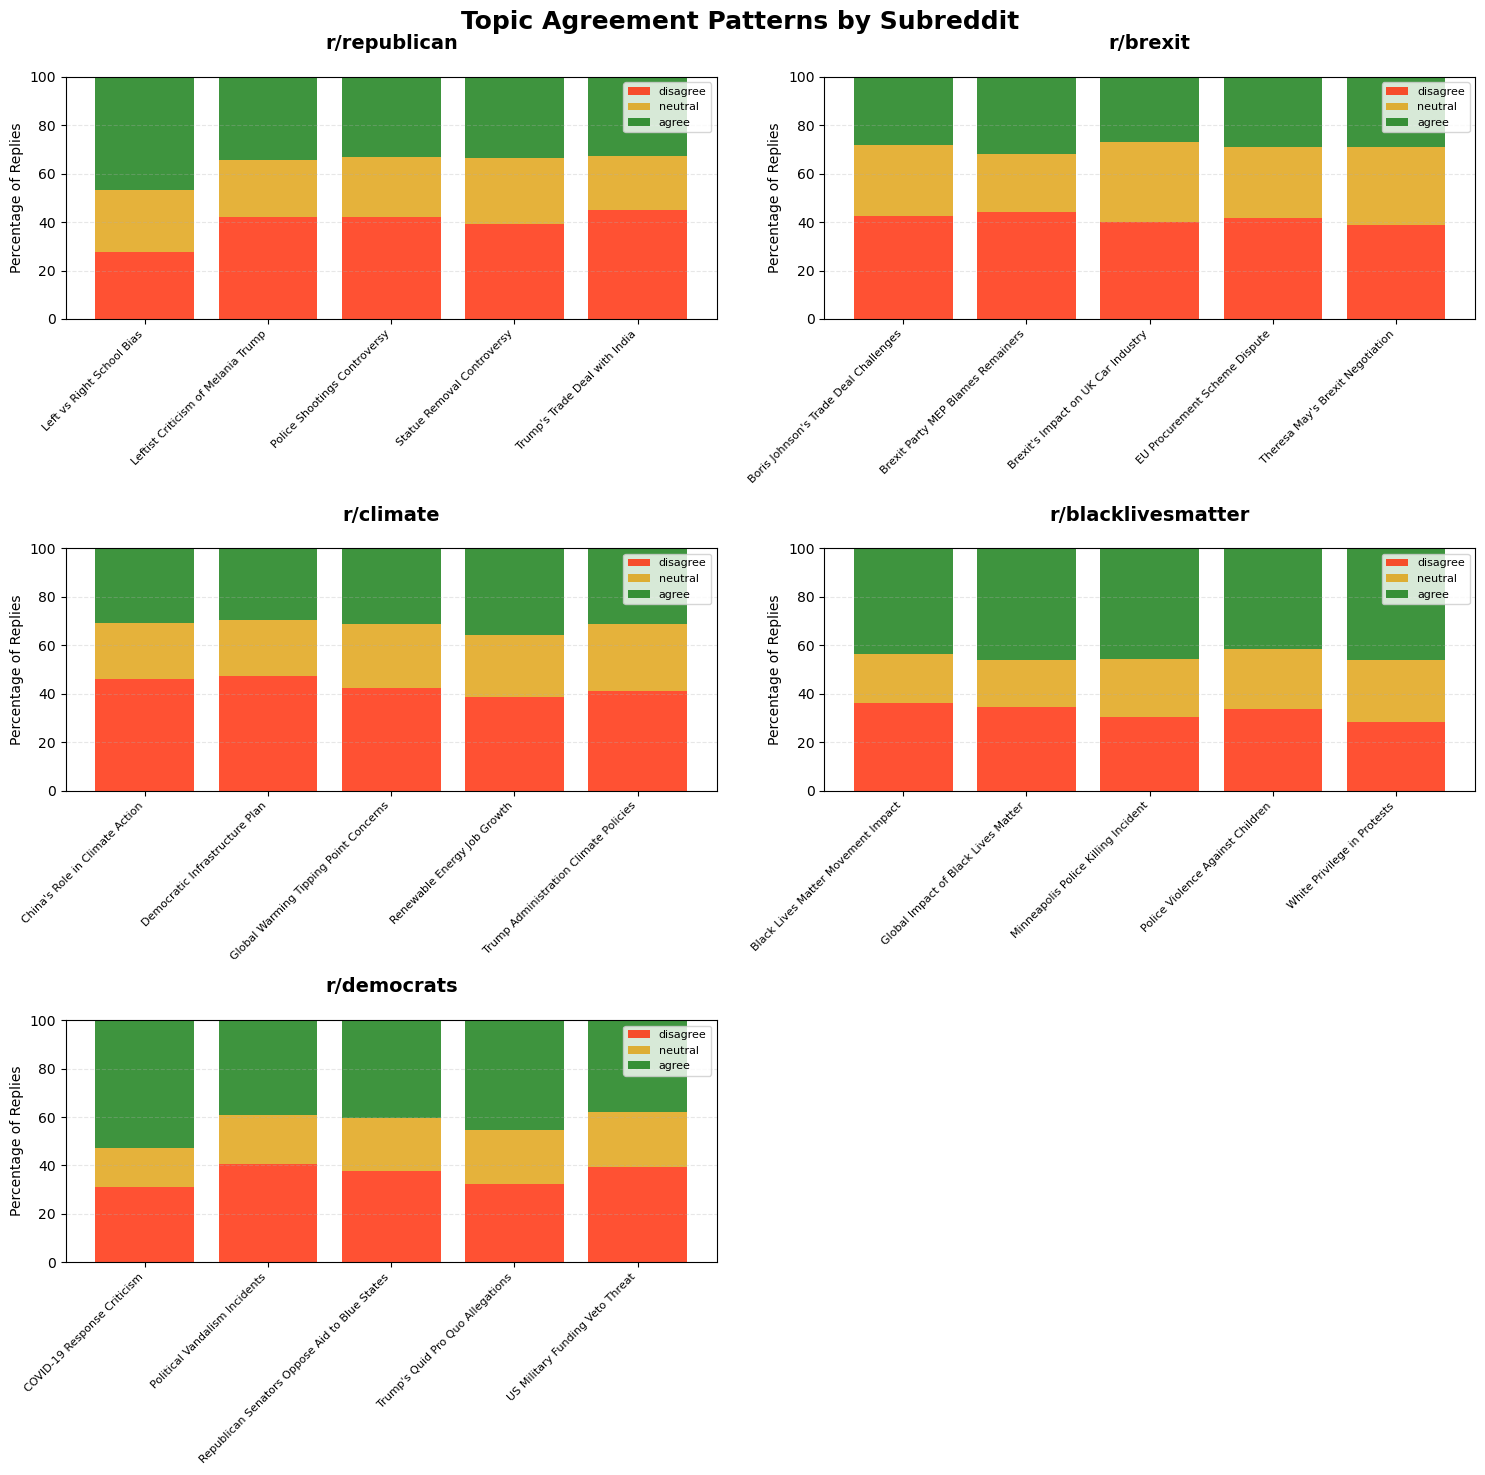

In [12]:
print("\nTopic Agreement Patterns (Top 5):")
topics_agreement = TopicVisualizer.plot_topic_agreement_by_subreddit(
    submissions, replies, 
    top_topics_per_sub=5, 
    figsize=(15, 15)
)


Subreddit Topics Bubble Plot:


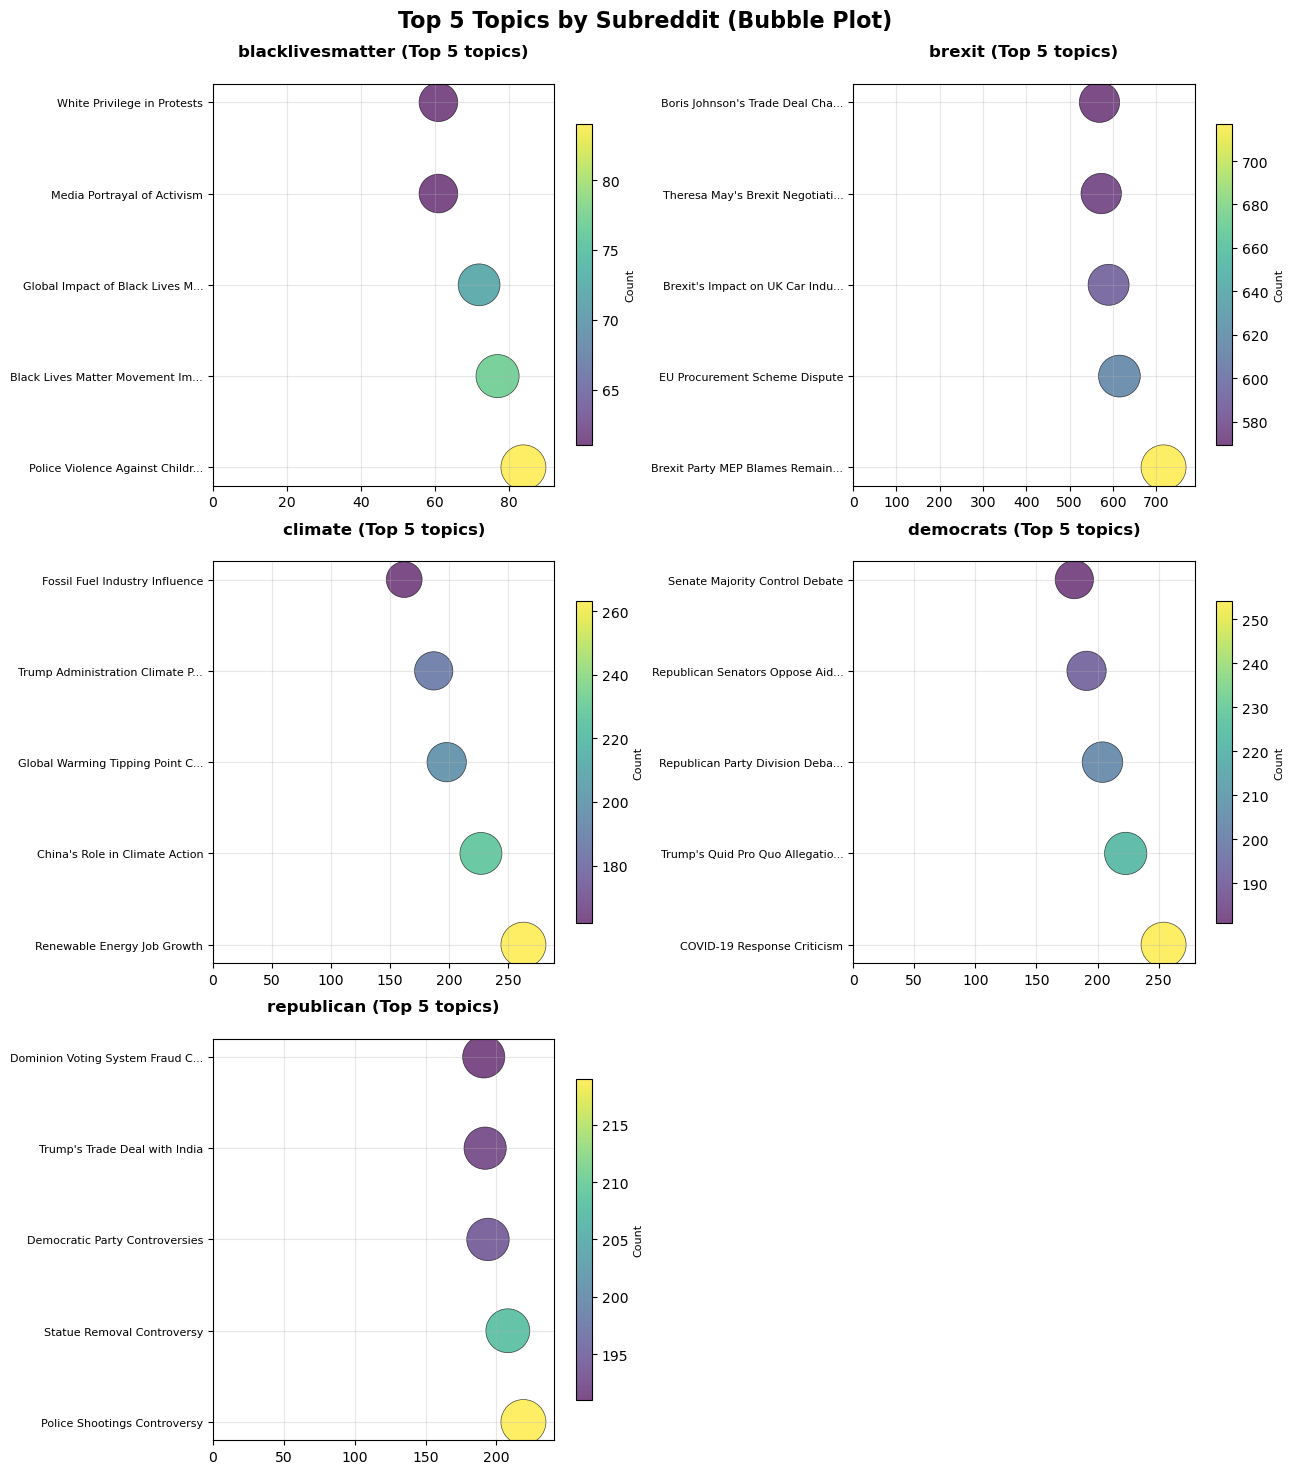

In [13]:
print("\nSubreddit Topics Bubble Plot:")
fig, axes = TopicVisualizer.plot_topic_bubble_subplots(
    topic_distribution=topic_distribution, 
    top_topics_per_sub=5, 
    figsize=(13, 15)
)

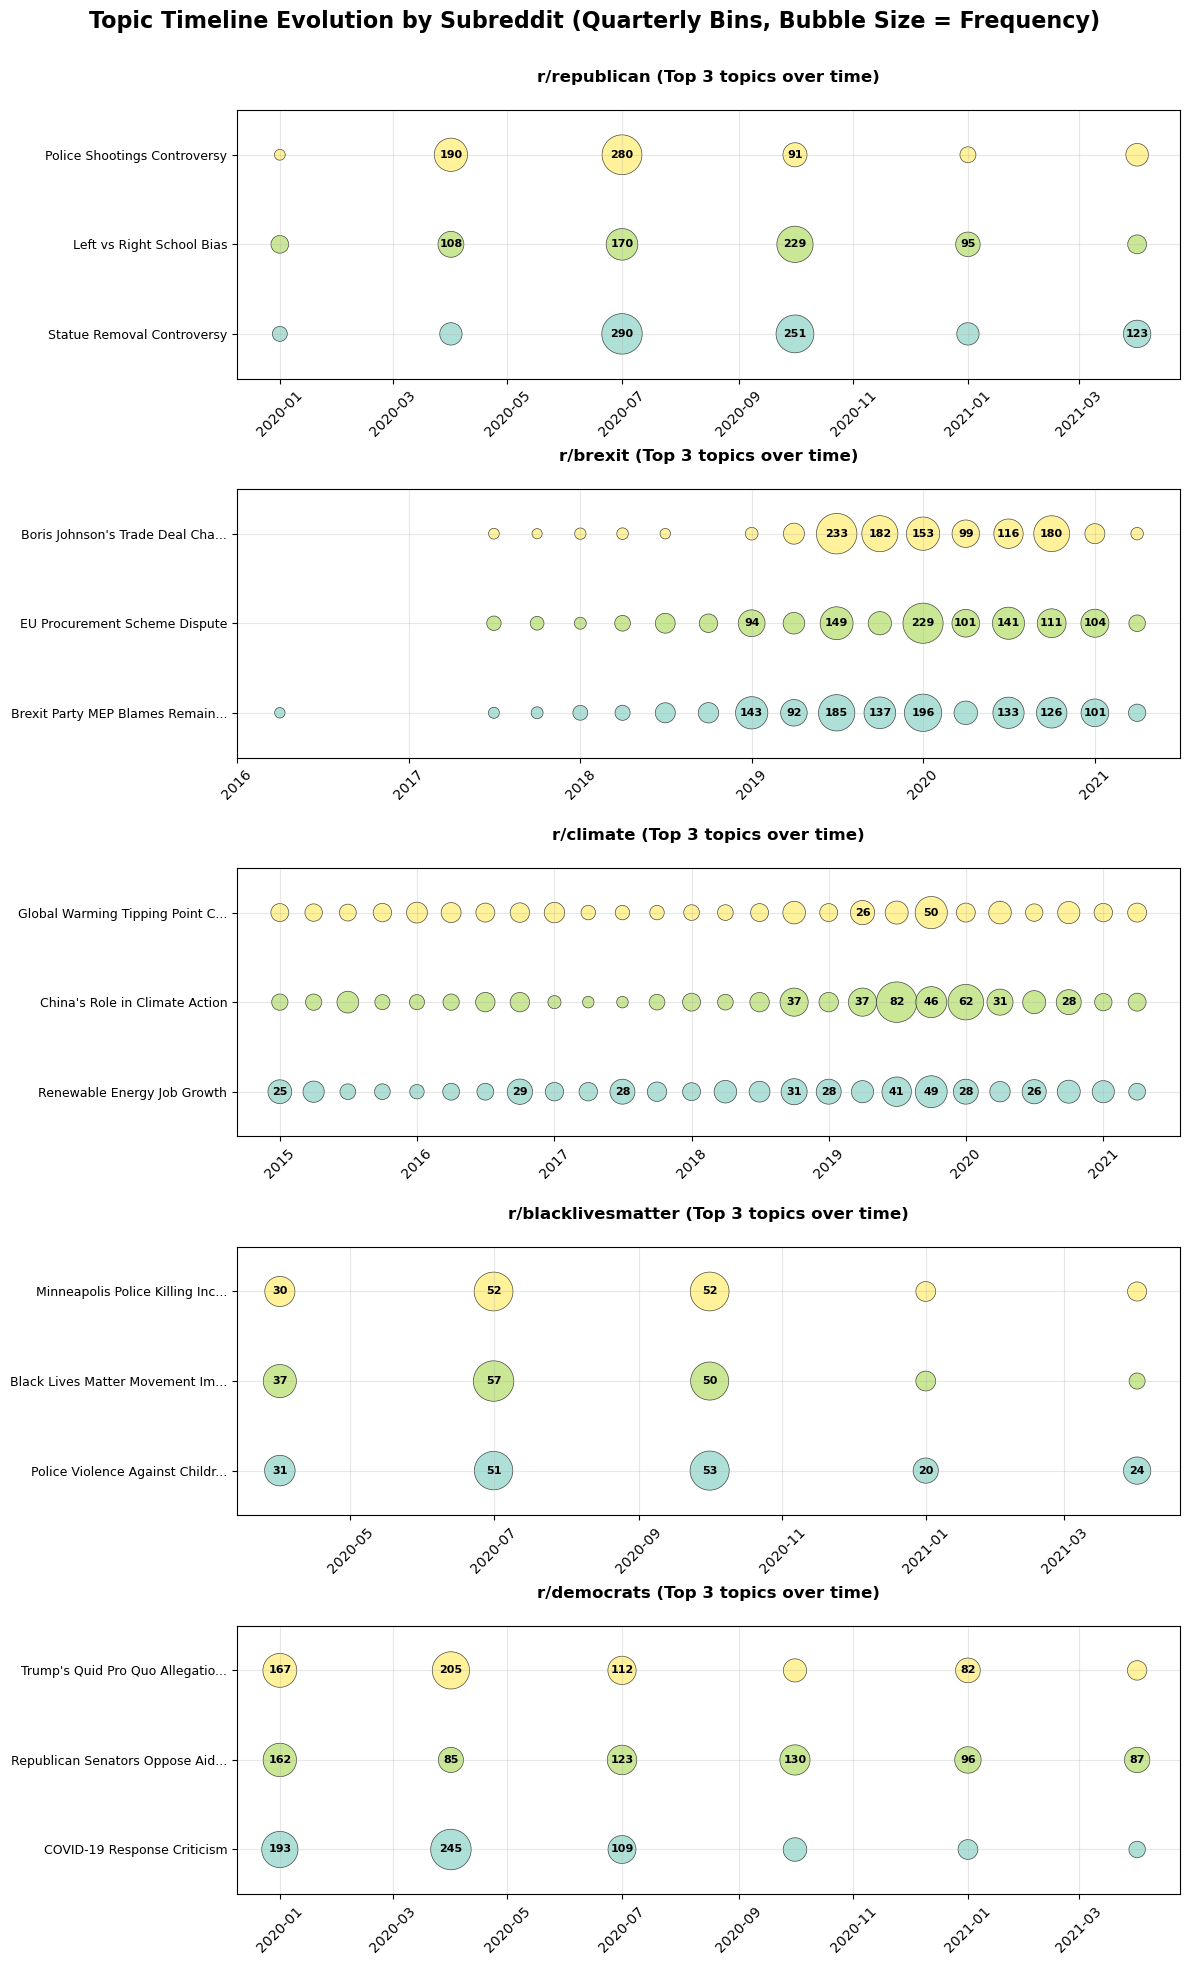

In [12]:
topics_timeline = TopicVisualizer.plot_topic_timeline_bubble_subplots(
    submissions_with_topics=submissions,
    raw=raw,
    top_topics_per_sub=3,  # Reduced for testing
    time_bins='Q',  # Quarterly bins
    figsize=(12, 20)
)
plt.show()